In [1]:
import os
import sys
from copy import deepcopy

project_dir = os.path.dirname(os.getcwd())
print(project_dir)
sys.path.append(project_dir)

import matplotlib.pyplot as plt
import numpy as np
from omegaconf import OmegaConf
# from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor
import torch
from torchvision.transforms import ToPILImage, ToTensor, Normalize
from training.dataset.transforms import ComposeAPI, NormalizeAPI
from tqdm import tqdm

from helpers.configurations import TRACK_TO_METAINFO
from dataset.collate_fn import collate_fn
from dataset.mini_dataset import MiniDataset
from debugging.show import *
from custom_model_builder import build_sam2_predict

/home/guests/tuna_gurbuz/prototype


In [2]:
# Dataset
object_labels = [10]
len_video = 1
input_image_size = 512
batch_size = 1
shuffle = False
mean = [0.3551, 0.3500, 0.3469]
std = [0.2921, 0.2716, 0.2742]
transforms = [ComposeAPI([NormalizeAPI(mean=mean, std=std, v2=True)])]
revert_mean=[-.3551/.2921, -.3500/.2716, -.3469/.2742]
revert_std=[1/.2921, 1/.2716, 1/.2742]
revert_transform = Normalize(mean=revert_mean, std=revert_std)
test_dataset = MiniDataset('over_train',
                           len_video=len_video,
                           input_image_size=input_image_size,
                           object_labels=object_labels,
                           transforms=transforms,
                           collate_fn=collate_fn,
                           batch_size=batch_size,
                           shuffle=shuffle,
                           get_seg_mask=True)
print(f'Lenght of the dataset! {len(test_dataset)}')

Loading the take 001_PKA!



  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:10<00:00,  3.54s/it]

Lenght of the dataset! 204


In [3]:
seed = 123  # Check seed 123 index 19966
torch.manual_seed(seed)
np.random.seed(seed)
# 035 idx 2761 has a problem!
# Image
len_objects = len(object_labels)
toPILimage = ToPILImage()
exist = False
exist_idx = []
idx = 0

for idx in tqdm(range(len(test_dataset))):
    if len(exist_idx) == 400:
        break
    # idx = 25424
    # print(f'Index: {idx}')
    frame_obj_list, frames_segmentation_mask = test_dataset[idx]
    image = frame_obj_list.frames[0].data
    # print('Input Image:')
    # toPILimage(revert_transform(image)).show()
    for j in range(len_objects):
        exist = torch.any(frame_obj_list.frames[0].objects[j].segment == True)
        # toPILimage(frame_obj_list.frames[0].objects[j].segment/255).show()
        exist_idx.append(idx) if exist else None

 17%|█▋        | 2932/17049 [02:14<10:46, 21.82it/s]


In [ ]:
exist_idx
# 1623 - 1632
# 2561 - 2931

[1297,
 1298,
 1530,
 1531,
 1532,
 1533,
 1534,
 1535,
 1536,
 1537,
 1538,
 1539,
 1540,
 1541,
 1542,
 1543,
 1544,
 1545,
 1623,
 1624,
 1625,
 1626,
 1627,
 1628,
 1629,
 1630,
 1631,
 1632,
 2560,
 2561,
 2562,
 2563,
 2564,
 2565,
 2566,
 2567,
 2568,
 2569,
 2570,
 2571,
 2572,
 2573,
 2574,
 2575,
 2576,
 2577,
 2578,
 2579,
 2580,
 2581,
 2582,
 2583,
 2584,
 2585,
 2586,
 2587,
 2588,
 2589,
 2590,
 2591,
 2592,
 2593,
 2594,
 2595,
 2596,
 2597,
 2598,
 2599,
 2600,
 2601,
 2602,
 2603,
 2604,
 2605,
 2606,
 2607,
 2608,
 2609,
 2610,
 2611,
 2612,
 2613,
 2614,
 2615,
 2616,
 2617,
 2618,
 2619,
 2620,
 2621,
 2622,
 2623,
 2624,
 2625,
 2626,
 2627,
 2628,
 2629,
 2630,
 2631,
 2632,
 2633,
 2634,
 2635,
 2636,
 2637,
 2638,
 2639,
 2640,
 2641,
 2642,
 2643,
 2644,
 2645,
 2646,
 2647,
 2648,
 2649,
 2650,
 2651,
 2652,
 2653,
 2654,
 2655,
 2656,
 2657,
 2658,
 2659,
 2660,
 2661,
 2662,
 2663,
 2664,
 2665,
 2666,
 2667,
 2668,
 2669,
 2670,
 2671,
 2672,
 2673,
 2674,

In [ ]:
len_data = len(test_dataset)
print(f'Length of the dataset: {len_data}')
camera_switch = (len_data//3, 2*len_data//3)
print(test_dataset.images[0], '\n', test_dataset.images[camera_switch[0]-1], '\n', test_dataset.images[camera_switch[0]])

Length of the dataset: 17049
[PosixPath('/home/polyaxon-data/data1/MM-OR_processed/001_PKA/colorimage/camera01_colorimage-000329.jpg')] 
 [PosixPath('/home/polyaxon-data/data1/MM-OR_processed/001_PKA/colorimage/camera01_colorimage-006011.jpg')] 
 [PosixPath('/home/polyaxon-data/data1/MM-OR_processed/001_PKA/colorimage/camera04_colorimage-000329.jpg')]


In [54]:
iid = 2868
cam1 = test_dataset.images[iid]
cam4 = test_dataset.images[iid + len_data//3]
cam5 = test_dataset.images[iid + 2*len_data//3]

# Use get item: 0) VideoDataBatch 1) Segmentation mask
cam1_vid = test_dataset[iid][0]
cam4_vid = test_dataset[iid + len_data//3][0]
cam5_vid = test_dataset[iid + 2*len_data//3][0]

# Use first frame
cam1 = cam1_vid.frames[0].data
cam4 = cam4_vid.frames[0].data
cam5 = cam5_vid.frames[0].data

gt_mask1 = cam1_vid.frames[0].objects[0].segment
gt_mask4 = cam4_vid.frames[0].objects[0].segment
gt_mask5 = cam5_vid.frames[0].objects[0].segment

print(gt_mask1.shape)
print(gt_mask1.dtype)

torch.Size([512, 512])
torch.uint8


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000001].


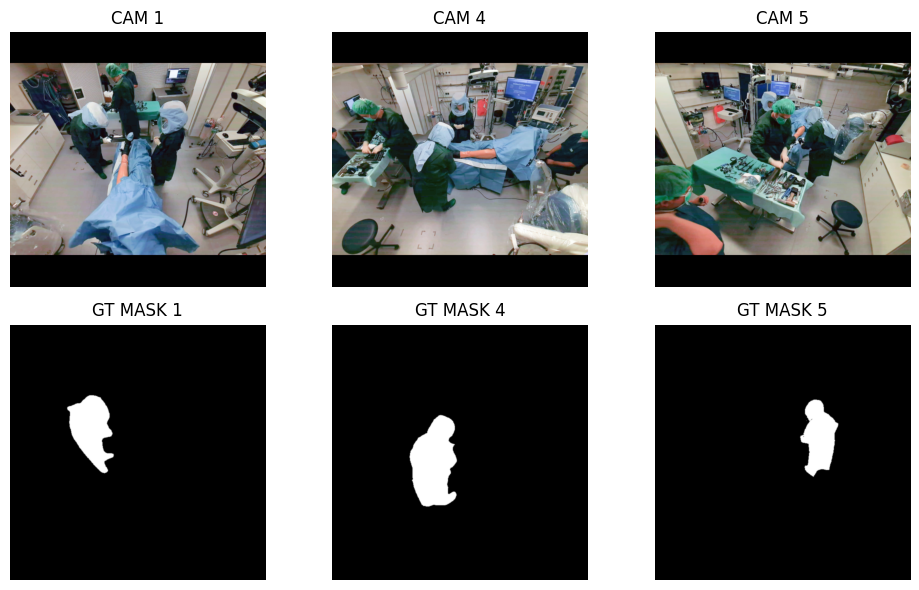

In [55]:
import matplotlib.pyplot as plt

# Create figure and subplots
fig, axes = plt.subplots(2, 3, figsize=(10, 6))

# Transpose from tensor to numpy shape
cam1 = revert_transform(cam1).permute(1,2,0)
cam4 = revert_transform(cam4).permute(1,2,0)
cam5 = revert_transform(cam5).permute(1,2,0)

# First row (RGB, GT, Black Placeholder)
axes[0,0].imshow(cam1)
axes[0,0].set_title("CAM 1")

axes[0,1].imshow(cam4)
axes[0,1].set_title("CAM 4")

axes[0,2].imshow(cam5)
axes[0,2].set_title("CAM 5")

axes[1,0].imshow(gt_mask1, cmap='gray')
axes[1,0].set_title("GT MASK 1")

axes[1,1].imshow(gt_mask4, cmap='gray')
axes[1,1].set_title("GT MASK 4")

axes[1,2].imshow(gt_mask5, cmap='gray')
axes[1,2].set_title("GT MASK 5")

# Remove axes for a cleaner look
for ax in axes.ravel():
    ax.axis('off')

# Show the plot
plt.tight_layout()
plt.show()